#### Importing packages

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import plotly as py
import plotly.express as px
import missingno as msno
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score
# to avoid warnings
import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")

#### Functions

In [2]:
# Function to remove missing values above a given threshold
def missing_remove(dataframe, threshold):
    columns = dataframe.columns[(dataframe.isna().sum()/dataframe.shape[1])>threshold].tolist()
    print(f"# Features deleted with more than {threshold} % missing values", len(columns))
    return dataframe.drop(columns, axis=1,inplace=True)

In [3]:
# Function to remove features with unique values
def unique_remove(dataframe):
    unique_features = []
    for col in dataframe.columns:
        if(dataframe[col].unique().size == 2):
            if(len(unique_features) == 0):
                unique_features =  dataframe[col]
            else:
                 unique_features = pd.concat([unique_features, dataframe[col]], axis=1)
            dataframe.drop(col, axis=1, inplace=True)

In [4]:
# Function to remove outlier
def outlier_detection_zcore(dataframe):
    data_mean, data_std  = dataframe.mean(), dataframe.std()
    data_z_scores = ((dataframe - data_mean) / data_std).abs()
    m = data_z_scores > 3
    dataframe = dataframe.mask(m,inplace=True)
    return dataframe

In [5]:
def rfc(X_train_rfc,X_test_rfc,y_train,max_depth):
  from matplotlib.pyplot import figure
  figure(figsize=(8, 5), dpi=80)
  model = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=max_depth)
  model.fit(X_train_rfc, y_train)
  y_pred = model.predict(X_test_rfc)
  sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d",yticklabels = ['Act. Fail', 'Act. Pass'], xticklabels = ['Pred. Fail' , 'Pred. Pass'])
  print(classification_report(y_test, y_pred))
  ax = plt.gca()
  plot = plot_roc_curve(model, X_test_rfc, y_test, ax=ax, alpha=0.8)
  print("Test Accuracy Score", accuracy_score(y_test, y_pred))
  f1score = f1_score(y_test, y_pred, average='micro')
  mccscore=matthews_corrcoef(y_test, y_pred)
  return f1score, mccscore

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, matthews_corrcoef
from yellowbrick.classifier import ConfusionMatrix, ClassPredictionError
def evaluate(train_df, test_df, train_target, test_target):
    
    scaler = StandardScaler()
    scaler.fit(train_df)
    train_std = pd.DataFrame(scaler.transform(train_df), columns=train_df.columns)
    test_std = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns)
    
    logreg = LogisticRegression(random_state = 42, class_weight='balanced', C=200, dual=False, solver='liblinear')
    logreg.fit(train_std, train_target.values.ravel())
    
    y_pred = logreg.predict(test_std)
    y_true = test_target.values.ravel()
    f1score = f1_score(y_true, y_pred, average='micro')
    mccscore=matthews_corrcoef(y_true, y_pred)
    
   
    cm = ConfusionMatrix(logreg, classes=['Fail', 'Pass'], cmap="YlGn", size=(400,400))
    cm.score(test_std, y_true)
    cm.show()
    from matplotlib.pyplot import figure
    figure(figsize=(5, 5), dpi=80)
    ax = plt.gca()
    plot = plot_roc_curve(logreg, test_df, test_target, ax=ax, alpha=0.8)
    
    return f1score, mccscore

#### Importing and basic cleaning

In [7]:
# Importing data from internet in runtime
data_url="https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data"

In [8]:
# Assigning data to a pandas dataframe
secom_data = pd.read_csv(data_url,sep=' ',header=None)

In [9]:
# Renaming the columns 
secom_data.columns = ["Feature_"+str(column+1) for column in range(len(secom_data.columns))]
secom_data.head()

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,...,Feature_581,Feature_582,Feature_583,Feature_584,Feature_585,Feature_586,Feature_587,Feature_588,Feature_589,Feature_590
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


In [10]:
# Importing target data from internet in runtime
label_url="https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data"

In [11]:
# Assigning target data to a pandas dataframe
secom_labels = pd.read_csv(label_url, sep = " ",header=None)

In [12]:
# Renaming the columns 
secom_labels.columns = ["Classification","Timestamp"]

In [13]:
# Changing datatype for consitency
secom_labels['Timestamp'] = pd.to_datetime(secom_labels['Timestamp'],errors='raise')

In [14]:
# Merging the data
data= pd.concat([secom_labels,secom_data],axis=1)

In [15]:
# Dropping the timestamp column as it provides no insights
data.drop(columns="Timestamp", errors='raise',inplace=True)

In [16]:
target = data[['Classification']]
data.drop(['Classification'], axis=1,inplace=True)

#### Spliting the data into training set and test set

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data,target, test_size=0.20, random_state=42, stratify=target)
# We use the startify parameter as the data is imbalanced on the basis of pass and fail and this will ensure the same 
#is retained when we split - Random state will help us create a reproducible data - Test size is the split ration

In [18]:
X_test_original = X_test

#### Re-labeling the Target values


In [19]:
# Relabeling target variables 1 is pass and 0 is fail
y_train = y_train.replace(to_replace=[-1, 1], value=[1, 0])
y_test = y_test.replace(to_replace=[-1, 1], value=[1, 0])

In [20]:
# # Scaling the data
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
# X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Decision : Removing columns with more that 50% missing values

In [21]:
X_train.shape

(1253, 590)

In [22]:
X_train_missing = X_train
missing_remove(X_train_missing, 0.5)
X_train_missing.shape

# Features deleted with more than 0.5 % missing values 32


(1253, 558)

In [23]:
# From test set deleting columns that are removed in training set
X_test_missing = X_test[np.array(X_train_missing.columns)]
X_test_missing.shape

(314, 558)

# Decision : Replacing outliers with 3s boundary

##### Other option of removing outliers and replacing them has been explored in file "Base file - removing outliers and replacing with knn.ipynb"

In [24]:
def replace_outlier(val, mean, std):
    if val > mean + 3*std:
        return mean + 3*std 
    elif val < mean - 3*std:
        return mean - 3*std
    return val

In [25]:
# replace with 3s in X_train
for col in X_train_missing.columns:
    mean = X_train_missing[col].mean()
    std_dev = X_train_missing[col].std(axis=0)
    X_train_missing[col] = X_train_missing[col].map(lambda x: replace_outlier(x, mean, std_dev))

In [26]:
# replace with 3s in X_test
for col in X_test_missing.columns:
    mean = X_test_missing[col].mean()
    std_dev = X_test_missing[col].std(axis=0)
    X_test_missing[col] = X_test_missing[col].map(lambda x: replace_outlier(x, mean, std_dev))

# Mice Imputation

In [27]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

MICE_imputer = IterativeImputer(random_state=100)
X_train_MICE = X_train_missing.copy(deep=True)
X_train_MICE.iloc[:,:] = pd.DataFrame(MICE_imputer.fit_transform(X_train_missing))
#X_train_MICE.index = X_train.index
#X_train = X_train_MICE

In [28]:
X_test_MICE = X_test_missing.copy(deep=True)
X_test_MICE.iloc[:,:] = pd.DataFrame(MICE_imputer.fit_transform(X_test_missing))
#X_test = X_test_MICE

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.93      1.00      0.97       293

    accuracy                           0.93       314
   macro avg       0.47      0.50      0.48       314
weighted avg       0.87      0.93      0.90       314

Test Accuracy Score 0.9331210191082803


(0.9331210191082803, 0.0)

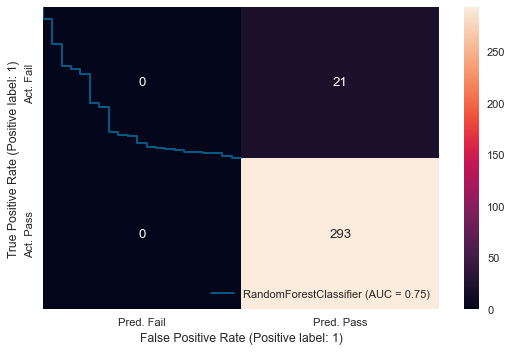

In [30]:
rfc(X_train_MICE,X_test_MICE,y_train,4)

# Feature Selection

## Boruta - 15 features

In [31]:
#Boruta function

def BorutaFeatureSelection (X, y) :
    feature_names = np.array(X.columns)

    model = model = RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', max_depth=5, random_state=100)
    model.fit(X, y)
    
    feature_selector = BorutaPy(model, n_estimators='auto', verbose=2, random_state=100, max_iter=100)

    feature_selector.fit(X.to_numpy(),y)

    feature_selector.support_

    feature_selector.ranking_

    feature_ranks = list(zip(feature_names, 
                             feature_selector.ranking_, 
                             feature_selector.support_))

    for feat in feature_ranks:
        print('Feature: {:<30} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))
        
    final_features = list()
    indexes = np.where(feature_selector.ranking_ <= 1)
    for x in np.nditer(indexes):
        final_features.append(feature_names[x])
    print(final_features)
    
    return pd.DataFrame(X.filter(final_features)) , final_features

In [32]:
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
X_train_boruta , final_features = BorutaFeatureSelection(X_train_MICE,y_train.values.ravel())

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	558
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	558
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	558
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	558
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	558
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	558
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	558
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	543
Iteration: 	9 / 100
Confirmed: 	5
Tentative: 	10
Rejected: 	543
Iteration: 	10 / 100
Confirmed: 	5
Tentative: 	10
Rejected: 	543
Iteration: 	11 / 100
Confirmed: 	5
Tentative: 	10
Rejected: 	543
Iteration: 	12 / 100
Confirmed: 	5
Tentative: 	10
Rejected: 	543
Iteration: 	13 / 100
Confirmed: 	5
Tentative: 	10
Rejected: 	543
Iteration: 	14 / 100
Confirmed: 	5
Tentative: 	10
Rejected: 	543
Iteration: 	15 / 100
Confirmed: 	5
Tentative: 	10
Rejected: 	543
Iteration: 	16 / 100
Confirmed: 	6
Tentat

In [33]:
# From test set deleting columns that are removed in training set
X_test_boruta = X_test_MICE[np.array(X_train_boruta.columns)]
X_test_boruta.shape

(314, 12)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.93      1.00      0.97       293

    accuracy                           0.93       314
   macro avg       0.47      0.50      0.48       314
weighted avg       0.87      0.93      0.90       314

Test Accuracy Score 0.9331210191082803


(0.9331210191082803, 0.0)

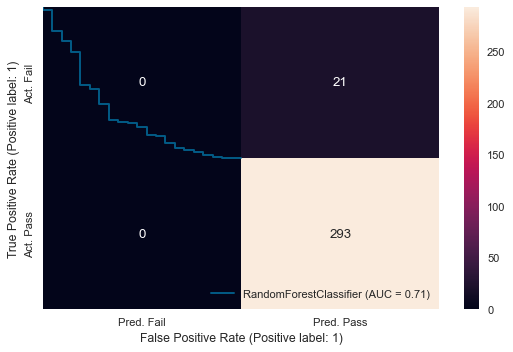

In [34]:
rfc(X_train_boruta,X_test_boruta,y_train,6)

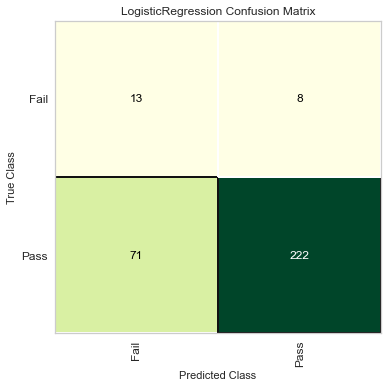

(0.7484076433121017, 0.2126015434221779)

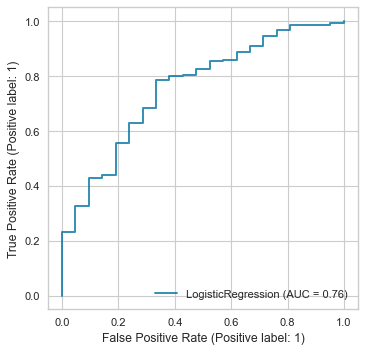

In [35]:
evaluate(X_train_boruta,X_test_boruta,y_train,y_test)

Text(0.5, 1.0, 'Heatmap for the Data')

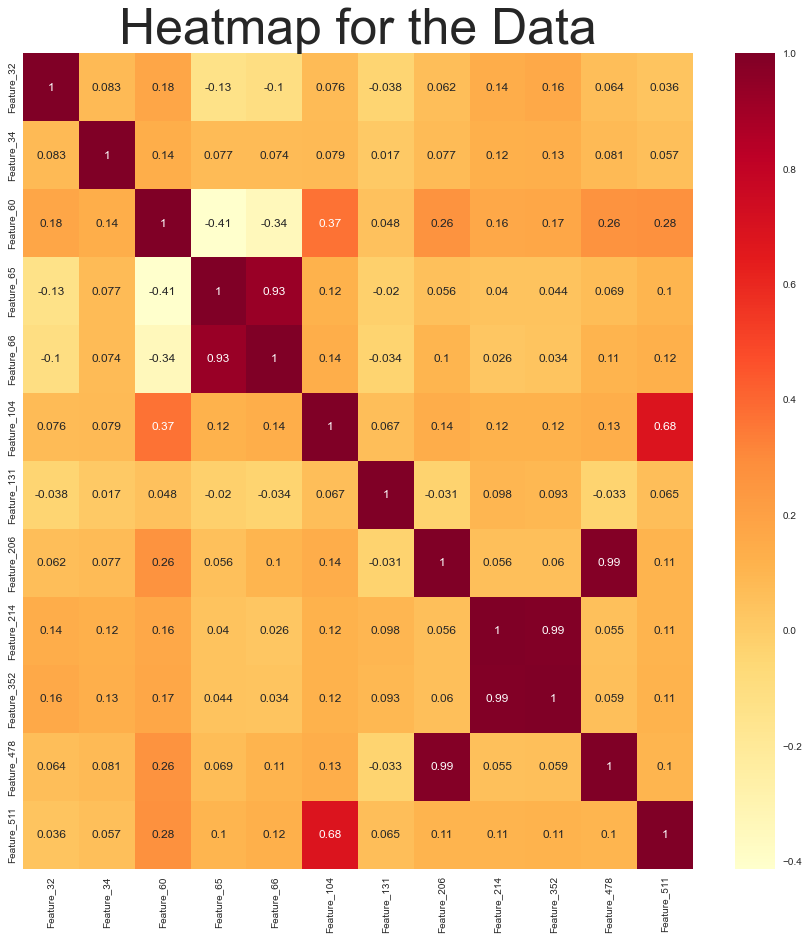

In [36]:
import seaborn as sns
# Heatmap for correlation
plt.rcParams['figure.figsize'] = (15,15)
sns.heatmap(X_train_boruta.corr(),cmap="YlOrRd",annot=True)
plt.title('Heatmap for the Data', fontsize = 50)

## Balancing usnig SMOTE

In [37]:
import numpy as np
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA

In [38]:
from imblearn.combine import SMOTETomek 
# Sampling technique

def Sampling(X_train, y_train, sampler):

    #SMOTE
    if sampler == 'SMOTE':
        sampler = SMOTE(random_state=100)    
    

    #SMOTTEENN
    if sampler == 'SMOTEENN' :
        sampler = SMOTEENN(random_state=100)
        
    # SMOTETOMEK
    
    if sampler == 'SMOTETOMEK' :
        sampler = SMOTETomek(random_state=100)

    #ADASYN
    if sampler == 'ADASYN':
        sampler = ADASYN(random_state=100)
        
    #ROSE
    if sampler == 'ROSE':
        sampler = RandomOverSampler(random_state=100, shrinkage=1)
        

    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    counter = Counter(y_resampled)
    print(counter)
    return X_resampled, y_resampled

In [39]:
# Imbalance treatment
from collections import Counter
X_smote, y_smote = Sampling(X_train_boruta, y_train,'SMOTE')

Counter({'Classification': 1})


              precision    recall  f1-score   support

           0       0.12      0.48      0.19        21
           1       0.95      0.74      0.83       293

    accuracy                           0.72       314
   macro avg       0.53      0.61      0.51       314
weighted avg       0.90      0.72      0.79       314

Test Accuracy Score 0.7229299363057324


(0.7229299363057324, 0.12144949768812659)

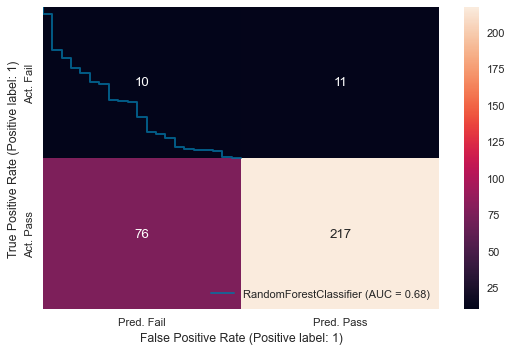

In [40]:
rfc(X_smote,X_test_boruta,y_smote,6)

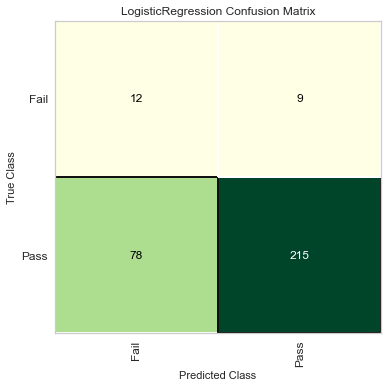

(0.7229299363057324, 0.1686191386563218)

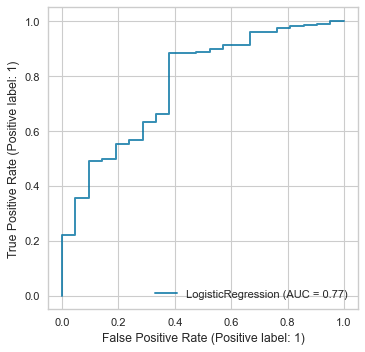

In [41]:
evaluate(X_smote,X_test_boruta,y_smote,y_test)

## Balancing using Smoteenn

In [42]:
# Imbalance treatment
from imblearn.combine import SMOTEENN
X_smoteenn, y_smoteenn = Sampling(X_train_boruta, y_train,'SMOTEENN')

Counter({'Classification': 1})


              precision    recall  f1-score   support

           0       0.12      0.57      0.21        21
           1       0.96      0.71      0.82       293

    accuracy                           0.70       314
   macro avg       0.54      0.64      0.51       314
weighted avg       0.90      0.70      0.78       314

Test Accuracy Score 0.7038216560509554


(0.7038216560509554, 0.15439270668513627)

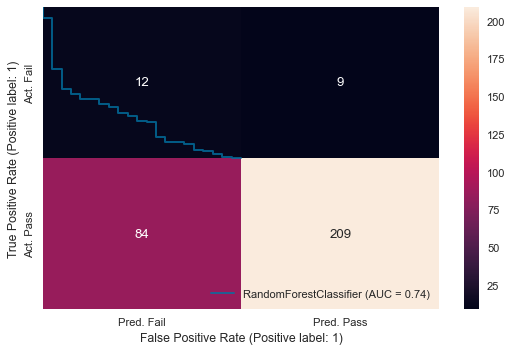

In [43]:
rfc(X_smoteenn,X_test_boruta,y_smoteenn,6)

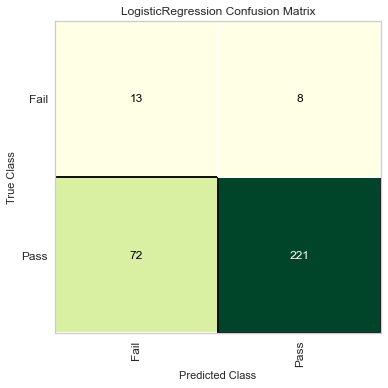

(0.7452229299363057, 0.2098893166666864)

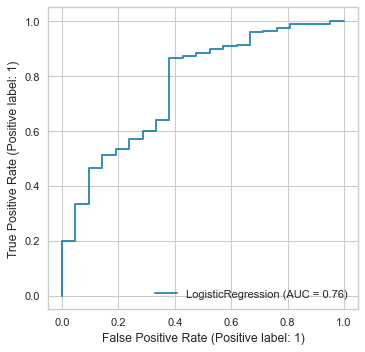

In [44]:
evaluate(X_smoteenn,X_test_boruta,y_smoteenn,y_test)

# Smotetomek

In [45]:
# Imbalance treatment
X_smotetomek, y_smotetomek = Sampling(X_train_boruta, y_train,'SMOTETOMEK')

Counter({'Classification': 1})


              precision    recall  f1-score   support

           0       0.11      0.48      0.18        21
           1       0.95      0.73      0.83       293

    accuracy                           0.72       314
   macro avg       0.53      0.60      0.51       314
weighted avg       0.90      0.72      0.79       314

Test Accuracy Score 0.7165605095541401


(0.7165605095541401, 0.11679479815745465)

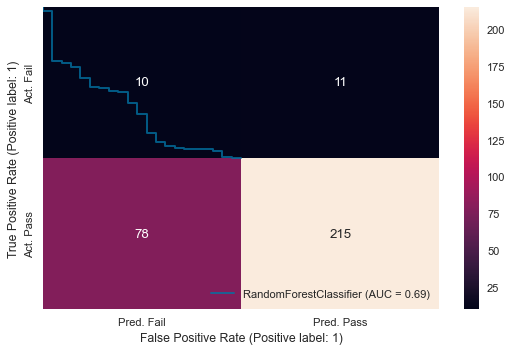

In [46]:
rfc(X_smotetomek,X_test_boruta,y_smotetomek,6)

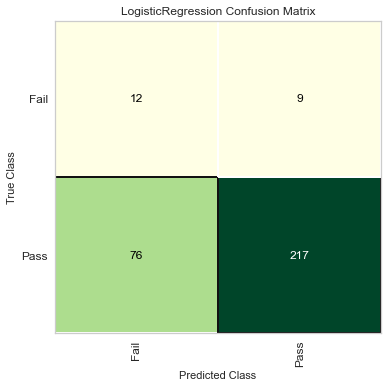

(0.7292993630573248, 0.17356502512562919)

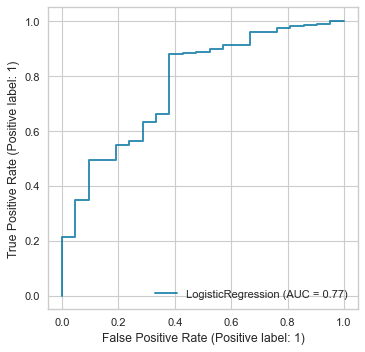

In [47]:
evaluate(X_smotetomek,X_test_boruta,y_smotetomek,y_test)

## Adasyn

In [48]:
# Imbalance treatment
X_adasyn, y_adasyn = Sampling(X_train_boruta, y_train,'ADASYN')

Counter({'Classification': 1})


              precision    recall  f1-score   support

           0       0.11      0.48      0.18        21
           1       0.95      0.72      0.82       293

    accuracy                           0.70       314
   macro avg       0.53      0.60      0.50       314
weighted avg       0.89      0.70      0.78       314

Test Accuracy Score 0.7038216560509554


(0.7038216560509554, 0.10775888173113132)

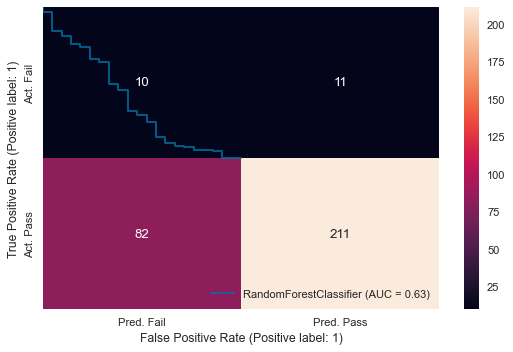

In [49]:
rfc(X_adasyn,X_test_boruta,y_adasyn,6)

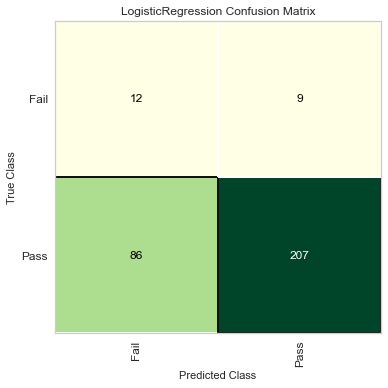

(0.697452229299363, 0.14983481619437264)

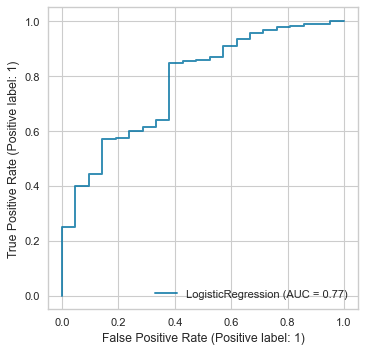

In [50]:
evaluate(X_adasyn,X_test_boruta,y_adasyn,y_test)

## Rose

In [51]:
# Imbalance treatment
X_rose, y_rose = Sampling(X_train_boruta, y_train,'ROSE')

Counter({'Classification': 1})


              precision    recall  f1-score   support

           0       0.18      0.57      0.28        21
           1       0.96      0.82      0.89       293

    accuracy                           0.80       314
   macro avg       0.57      0.70      0.58       314
weighted avg       0.91      0.80      0.85       314

Test Accuracy Score 0.802547770700637


(0.802547770700637, 0.2407986020958898)

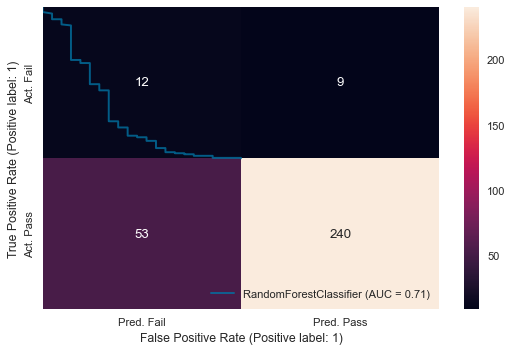

In [52]:
rfc(X_rose,X_test_boruta,y_rose,6)

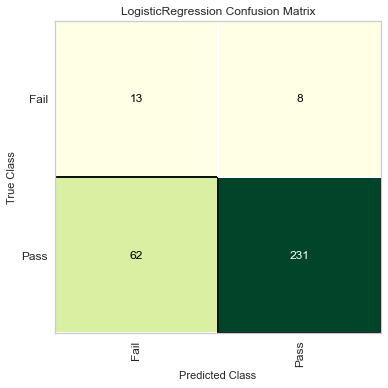

(0.7770700636942676, 0.2387158711395706)

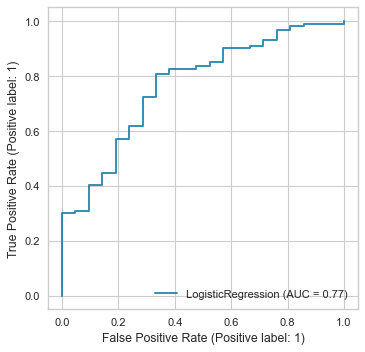

In [53]:
evaluate(X_rose,X_test_boruta,y_rose,y_test)